In [1]:
import pandas as pd
import numpy as np
import os
import pickle


In [2]:
delim = ';'

user_count = 100

base_path = '/opt/iui-datarelease1-sose2021/'

Xpickle_file = './X.pickle'

ypickle_file = './y.pickle'

In [3]:
def load_pickles():
    _p = open(Xpickle_file, 'rb')
    X = pickle.load(_p)
    _p.close()
        
    _p = open(ypickle_file, 'rb')
    y = pickle.load(_p)
    _p.close()
    
    return (np.asarray(X, dtype=pd.DataFrame), np.asarray(y, dtype=str))

In [4]:
def load_data():
    if os.path.isfile(Xpickle_file) and os.path.isfile(ypickle_file):
        return load_pickles()
    data = []
    label = []
    for user in range(0, user_count):
        user_path = base_path + str(user) + '/split_letters_csv/'
        for file in os.listdir(user_path):
            file_name = user_path + file
            letter = ''.join(filter(lambda x: x.isalpha(), file))[0]
            data.append(pd.read_csv(file_name, delim))
            label.append(letter)
    return (np.asarray(data, dtype=pd.DataFrame), np.asarray(label, dtype=str))

In [11]:
def save_pickle():
#     _p = open(np.asarray(data, dtype=pd.DataFrame), 'wb')
    _p = open(Xpickle_file, 'wb')
    pickle.dump(X, _p)
    _p.close()

#     _p = open(np.asarray(label, dtype=str), 'wb')
    _p = open(ypickle_file, 'wb')
    pickle.dump(y, _p)
    _p.close()

In [6]:
len(X), len(y)

(13102, 13102)

count    13102.000000
mean       208.304457
std        206.732342
min         42.000000
50%        185.000000
90%        270.000000
91%        276.000000
92%        286.000000
93%        299.000000
94%        312.000000
95%        333.000000
96%        355.000000
97%        388.000000
98%        456.980000
99%        701.940000
max      11073.000000
dtype: float64

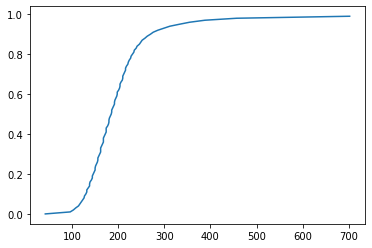

In [7]:
import matplotlib.pyplot as plt

X_len = np.asarray(list(map(len, X)))
l = []
sq_xlen = pd.Series(X_len)
ptiles = [x*0.01 for x in range(100)]
for i in ptiles:
    l.append(sq_xlen.quantile(i))
plt.plot(l, ptiles)
sq_xlen.describe(percentiles=[x*0.01 for x in range(90,100)])

In [49]:
def fill(x, threshold):
    fill = threshold - len(x)
    xx = x
    for i in range(fill):
        xx = xx.append(pd.Series(0,index=x.columns,dtype='float64'), ignore_index=True)
    return xx

In [56]:
threshold_p = 0.98
threshold = int(sq_xlen.quantile(threshold_p))
len_mask = np.where(X_len <= threshold)

X_filter = X[len_mask]
y_filter = y[len_mask]

In [57]:
%%time
X_filter = list(map(fill, X_filter, [threshold for i in range(len(X_filter))]))

CPU times: user 41min 37s, sys: 1.15 s, total: 41min 38s
Wall time: 41min 59s


In [51]:
def plot_data(data):
    fig, axs = plt.subplots(4, 3, figsize=(3*3, 3*4))
    t = data['Millis']
    axs[0][0].plot(t, data['Acc1 X'])
    axs[0][1].plot(t, data['Acc1 Y'])
    axs[0][2].plot(t, data['Acc1 Z'])
    axs[1][0].plot(t, data['Acc2 X'])
    axs[1][1].plot(t, data['Acc2 Y'])
    axs[1][2].plot(t, data['Acc2 Z'])
    axs[2][0].plot(t, data['Gyro X'])
    axs[2][1].plot(t, data['Gyro Y'])
    axs[2][2].plot(t, data['Gyro Z'])
    axs[3][0].plot(t, data['Mag X'])
    axs[3][1].plot(t, data['Mag Y'])
    axs[3][2].plot(t, data['Mag Z'])

    for a in axs:
        for b in a:
            b.plot(t, data['Force'])


In [8]:
Xfiltered_pickle_file = './X_filter.pickle'
yfiltered_pickle_file = "./y_filter.pickle"

In [63]:
def save_filtered():
    _p = open(Xfiltered_pickle_file, 'wb')
    pickle.dump(X_filter, _p)
    _p.close()

    _p = open(yfiltered_pickle_file, 'wb')
    pickle.dump(y_filter, _p)
    _p.close()

In [64]:
save_filtered()

In [9]:
def load_filtered_pickles():
    _p = open(Xfiltered_pickle_file, 'rb')
    X = pickle.load(_p)
    _p.close()
        
    _p = open(yfiltered_pickle_file, 'rb')
    y = pickle.load(_p)
    _p.close()
    
    return (np.asarray(X, dtype=pd.DataFrame), np.asarray(y, dtype=str))

In [10]:
XX_filtered, yy_filtered = load_filtered_pickles()

In [13]:
# FIRST CELL: set these variables to limit GPU usage.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '2'          # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf

lb = LabelBinarizer()

yyt_filtered = lb.fit_transform(yy_filtered)
XX_filtered = np.asarray(XX_filtered).astype('float64')
XXX_filtered = np.delete(XX_filtered, 0, 2)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(XXX_filtered, yyt_filtered, test_size=0.2, random_state=177013)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10271, 456, 14)
(2568, 456, 14)
(10271, 26)
(2568, 26)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

model = Sequential()

# model.add(Conv1D(32, 3, input_shape = X_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=3))

# model.add(Conv1D(32, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=3))

model.add(Flatten(input_shape=(456,14)))

model.add(Dense(456, activation='relu'))

model.add(Dense(26, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy", 
    metrics=["acc"],
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 6384)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 456)               2911560   
_________________________________________________________________
dense_7 (Dense)              (None, 26)                11882     
Total params: 2,923,442
Trainable params: 2,923,442
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train.shape, y_train.shape

((10271, 456, 14), (10271, 26))

In [28]:
model.fit(X_train, y_train, 
          epochs=10,
          batch_size=64,
          shuffle=True,
          verbose=1
         )

Epoch 1/10
161/161 [==============================] - 1s 2ms/step - loss: 8658.2280 - acc: 0.0409
Epoch 2/10
161/161 [==============================] - 0s 2ms/step - loss: 26.3454 - acc: 0.0447
Epoch 3/10
161/161 [==============================] - 0s 2ms/step - loss: 10.9452 - acc: 0.0422
Epoch 4/10
161/161 [==============================] - 0s 2ms/step - loss: 3.9099 - acc: 0.0437
Epoch 5/10
161/161 [==============================] - 0s 2ms/step - loss: 3.5461 - acc: 0.0474
Epoch 6/10
161/161 [==============================] - 0s 2ms/step - loss: 4.2588 - acc: 0.0423
Epoch 7/10
161/161 [==============================] - 0s 2ms/step - loss: 3.3213 - acc: 0.0414
Epoch 8/10
161/161 [==============================] - 0s 2ms/step - loss: 3.2681 - acc: 0.0451
Epoch 9/10
161/161 [==============================] - 0s 2ms/step - loss: 3.2482 - acc: 0.0422
Epoch 10/10
161/161 [==============================] - 0s 2ms/step - loss: 3.2693 - acc: 0.0435


In [30]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("predictions shape:", predictions.shape)4

lb.inverse_transform(y_test[:3]), lb.inverse_transform(predictions)

Evaluate on test data
81/81 [==============================] - 0s 2ms/step - loss: 19.9920 - acc: 0.0331
test loss, test acc: [19.992048263549805, 0.033099688589572906]
Generate predictions for 3 samples
predictions shape: (3, 26)


(array(['K', 'T', 'U'], dtype='<U1'), array(['T', 'T', 'T'], dtype='<U1'))

In [3]:
exit()

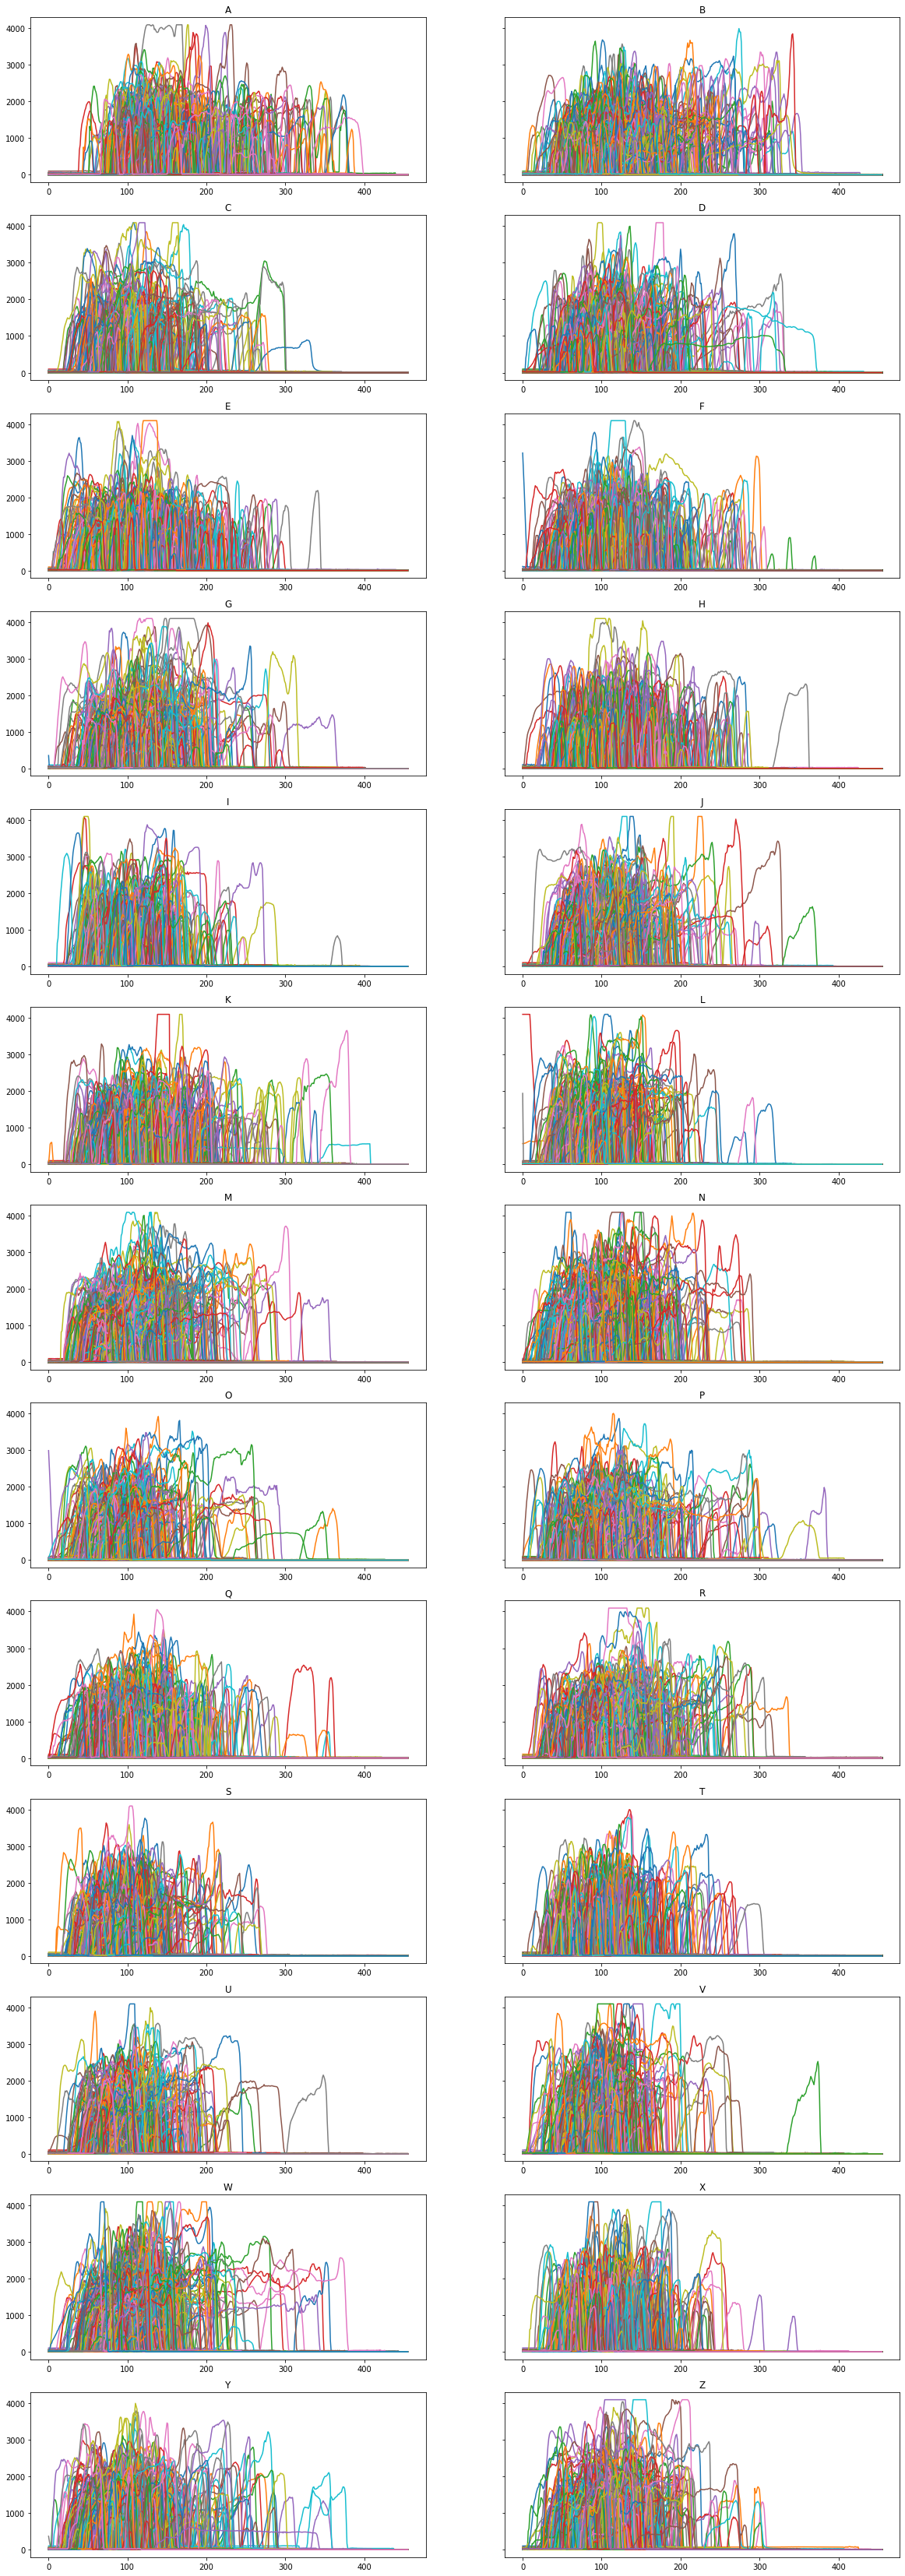

In [54]:
fig, axs = plt.subplots(13,2,figsize=(20, 60), sharey=True)
for i,j in zip(XXX_filtered, yy_filtered):
    num = ord(j) - 64
    f = i.T[12]
    r = int((num-1)/2)%13
    c = (num-1)%2
    axs[r][c].title.set_text(f'{j}')
    axs[r][c].plot(f)